# 1. Data Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchani

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("ani_gdb_s01_to_s04.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [4]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


In [5]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

In [6]:
batch_size = 4096
train_data_loader = train_data.collate(batch_size=batch_size).cache()
val_data_loader = val_data.collate(batch_size=batch_size).cache()
test_data_loader = test_data.collate(batch_size=batch_size).cache()

# 2. Network Construction and Workflow Development

## 2.1. ANITrainer

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        train_data_batch = next(iter(train_data_loader))

        # definition of loss function: MSE is a good choice! 
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_samples = 0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred_energies = self.model((species, coords))
                
                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_importance
                num_samples += batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            train_epoch_loss /= num_samples
            val_epoch_loss = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(batch_size=self.batch_size).cache()
        train_data_batch = next(iter(train_data_loader))

        # init loss function
        loss_func = nn.MSELoss()
        total_loss = 0.0
        num_samples = 0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred_energies = self.model((species, coords))
                 
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = species.shape[0]
                total_loss += batch_loss.item() * batch_importance
                num_samples += batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        total_loss /= num_samples

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

## 2.2. Demonstration on a subset

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


Validation Loss: 7.435047816464e-05


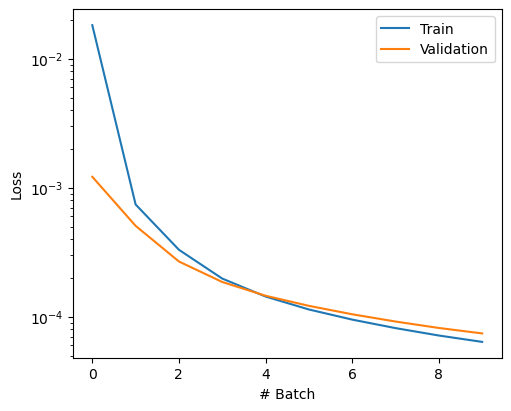

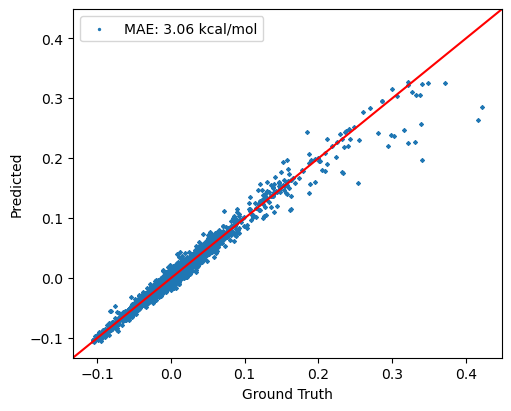

In [26]:
# train the ANITrainer
trainer = ANITrainer(model, batch_size=4096, learning_rate=1e-4, epoch=10, l2=1e-5)
train_loss_list, val_loss_list = trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
val_loss = trainer.evaluate(val_data, draw_plot=True)
print("Validation Loss:", val_loss)

# 3. Regularization and Hyperparameter Tuning

## 3.1. Data Augmentation

In [16]:
!curl -L https://ndownloader.figshare.com/files/9057631 -o ANI1_release.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4584M  100 4584M    0     0  12.8M      0  0:05:57  0:05:57 --:--:-- 19.8M97k


In [21]:
!tar -xzf ANI1_release.tar.gz

In [11]:
import h5py
import glob

def merge_hdf5_groups(input_dir, output_file):
    # file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0*.h5"))
    file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0[1-6].h5"))
    if not file_list:
        print("No HDF5 files found in the input directory")
        return
    
    with h5py.File(output_file, 'w') as fout:
        for file in file_list:
            print(f"Processing {file}...")
            with h5py.File(file, 'r') as fin:
                for key in fin.keys():
                    new_key = key
                    suffix = 1
                    while new_key in fout:
                        new_key = f"{key}_{suffix}"
                        suffix += 1
                    fin.copy(key, fout, new_key)
                    print(f"Copied group '{key}' as '{new_key}'")
    print(f"Merged groups from {len(file_list)} files into {output_file}")


input_directory = "./ANI-1_release"
output_h5_file = "./ani_gdb_s01_to_s06.h5"
merge_hdf5_groups(input_directory, output_h5_file)

Processing ./ANI-1_release/ani_gdb_s01.h5...
Copied group 'gdb11_s01' as 'gdb11_s01'
Processing ./ANI-1_release/ani_gdb_s02.h5...
Copied group 'gdb11_s02' as 'gdb11_s02'
Processing ./ANI-1_release/ani_gdb_s03.h5...
Copied group 'gdb11_s03' as 'gdb11_s03'
Processing ./ANI-1_release/ani_gdb_s04.h5...
Copied group 'gdb11_s04' as 'gdb11_s04'
Processing ./ANI-1_release/ani_gdb_s05.h5...
Copied group 'gdb11_s05' as 'gdb11_s05'
Processing ./ANI-1_release/ani_gdb_s06.h5...
Copied group 'gdb11_s06' as 'gdb11_s06'
Merged groups from 6 files into ./ani_gdb_s01_to_s06.h5


In [9]:
# Reload the dataset with augmented ANI-1 dataset
dataset = load_ani_dataset("./ani_gdb_s01_to_s06.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [10]:
# Initialize aev computer
aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


## 3.2. Regularization

In [11]:
# Apply Dropout
class AtomicNet(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [12]:
def create_ani_model(dropout_rate=0.0):
    net_H = AtomicNet(dropout_rate)
    net_C = AtomicNet(dropout_rate)
    net_N = AtomicNet(dropout_rate)
    net_O = AtomicNet(dropout_rate)

    # ANI model requires a network for each atom type
    # use torch.ANIModel() to compile atomic networks
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    model = nn.Sequential(
        aev_computer,
        ani_net
    ).to(device)
        
    return model

In [13]:
# We already had L2 regularization as `weight_decay`
# Add L1 regularization term
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2, l1=0.0):
        self.model = model.to(device)
        
        # Count total number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        # Hyperparameters setting
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        self.l1 = l1  # L1 regularization strength

    def train(self, train_data, val_data, early_stop=True, draw_curve=False):
        self.model.train()
        print("Initializing training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        
        loss_func = nn.MSELoss()
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        best_weights = None

        for epoch_idx in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_samples = 0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(true_energies, pred_energies)
                
                # Add L1 regularization loss
                if self.l1 > 0:
                    l1_loss = 0.0
                    for param in self.model.parameters():
                        l1_loss += torch.norm(param, 1)
                    batch_loss += self.l1 * l1_loss
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_size_current = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_size_current
                num_samples += batch_size_current

            train_epoch_loss /= num_samples
            train_loss_list.append(train_epoch_loss)
            val_epoch_loss = self.evaluate(val_data)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    best_weights = self.model.state_dict().copy()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            plt.show()
        
        if early_stop and best_weights is not None:
            self.model.load_state_dict(best_weights)
        
        return train_loss_list, val_loss_list

    def evaluate(self, data, draw_plot=False):
        data_loader = data.collate(batch_size=self.batch_size).cache()
        loss_func = nn.MSELoss()
        total_loss = 0.0
        num_samples = 0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
        
        self.model.eval()
        with torch.no_grad():
            for batch_data in data_loader:
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(pred_energies, true_energies)
                batch_size_current = species.shape[0]
                total_loss += batch_loss.item() * batch_size_current
                num_samples += batch_size_current
                
                if draw_plot:
                    true_energies_all.append(true_energies.cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.cpu().numpy().flatten())

        total_loss /= num_samples
        
        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Convert hartree to kcal/mol (1 hartree = 627.5094738898777 kcal/mol)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            vmin = min(ax.get_xlim()[0], ax.get_ylim()[0])
            vmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            plt.show()
            
        return total_loss

## 3.3. Hyperparameter Tuning

In [14]:
# We will experiment various combination of hyperparameters
# Grid search enables finding optimal hyperparameter setting more efficiently than random search
# Define hyperparameter grids
hyperparams = [
    # (dropout_rate, learning_rate, batch_size, l2, l1, epoch)
    (0.4, 1e-4, 4096, 1e-5, 0.0, 10), # best setting in ckpt3
    (0.0, 1e-4, 4096, 1e-5, 0.0, 10),
    (0.4, 1e-4, 1024, 1e-5, 0.0, 10),
    
]

# Record each experiment's hyperparameters and validation loss
results = []

best_val_loss = np.inf
best_params = None
best_trainer = None

# Grid search loop
for idx, params in enumerate(hyperparams):
    print(f"\n---- Experiment {idx+1} ----")
    dropout_rate, learning_rate, batch_size, l2, l1, epoch = params
    
    # Create a new ANI model using the specified dropout rate
    model = create_ani_model(dropout_rate)
    
    # Initialize the trainer with current hyperparameter settings
    trainer = ANITrainer(model, batch_size, learning_rate, epoch, l2, l1)
    
    trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
    val_loss = trainer.evaluate(val_data, draw_plot=True)
    print(f"Experiment {idx+1} - Validation Loss:",val_loss)
    
    exp_result = {
        'experiment': idx+1,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'l2': l2,
        'l1': l1,
        'epoch': epoch,
        'val_loss': val_loss
    }
    results.append(exp_result)
    
    # Based on the current validation loss, update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_trainer = trainer


---- Experiment 1 ----
Sequential - Number of parameters: 197636
Initializing training data...


KeyboardInterrupt: 

In [ ]:
import pickle
with open("grid_search_results.pkl", "wb") as f:
    pickle.dump(results, f)
print("Grid search results saved to grid_search_results.pkl")

print("\n---- Best Hyperparameter Combination ----")
print(f"Dropout Rate: {best_params[0]}, Learning Rate: {best_params[1]}, Batch Size: {best_params[2]}, "
      f"L2: {best_params[3]}, L1: {best_params[4]}, Epoch: {best_params[5]}")
print(f"Best Validation Loss:", best_val_loss)

# Evaluate the best model on test_data
test_loss = best_trainer.evaluate(test_data, draw_plot=True)
print(f"Test Loss:", test_loss)

In [ ]:
import pandas as pd
df_results = pd.DataFrame(results)
print("\nGrid Search Results:")
print(df_results)

# Visualization of validation loss for each experiment
plt.figure(figsize=(8, 6))
plt.bar(df_results['experiment'].astype(str), df_results['val_loss'])
plt.xlabel('Experiment')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Experiment')
plt.savefig("val_loss_bar.png")
plt.show()

## Interpretation of Results

In checkpoint 2, we used ANI-1 subset of s01 to s04, and we set hyperparameters as batch_size=8192, learning_rate=1e-4, epoch=10, l2=1e-5. The result of training was MAE = 3.40kcal/mol, which was reasonable, but there was the room for improvement. In this checkpoint, we increased the dataset to s06, and adjusted hyperparameter values and regularization to find out the best model that we can come up with.
We did 7 experiments with different hyperparameter values and compared their MAE and validation loss, and got Exp4 with dropout_rate=0.4, batch=4096, learning rate = 1e-4, l2=1e-5, and l2=0.0 as the best model with lowest MAE (2.19kcal/mol) and validation loss (10.71).

### Batch Size

For the batch size, while all other experiments were batch = 8192, only Exp4 was lowered by half (4096). This resulted in huge improvement, compared to Exp2 where all the other parameters except batch size was same, as the validation loss was cut by 40% (from 17.9 to 10.7). Although we did not experiment with smaller batch size, it seems that size of 4096 is very suitable in this model.

### Dropout

In case of dropout, we compared which dropout rate is best using Exp1 to Exp3 validation loss. In Exp1 (0.0) -> Exp2 (0.4), the loss was worsened slightly (15.8 to 17.9). From Exp2(0.4) to Exp3(0.6) the loss worsened further. However, when dropout rate was 0.4 and batch size became smaller (Exp4), the loss was the lowest. By this result, we can see that too much droput hurts, but small dropout with smaller batch size might help.

### L2 and L1 Regularization

In the case of l1, which we used in Exp5, it makes the catastrophic result as the loss shooted up to 199.5. This can mean that many weights were forced to zero early, making the model have a hard time to learn. For l2, when we adjusted l2=1e-5 to 1e-4, the loss became 4 times larger than Exp4, which had all the same parameters except l2. From these results, we can conclude that model with no l1 and l2=1e-5 works best.

### Learning Rate

Halving lr from 1e‑4 to 5e‑5 (Exp 6) doubles the loss (17.9 -> 31.8). Ten epochs are apparently not enough for the smaller step size to reach a good minimum, so there should probably be more epochs to find out the possible optimum learning rate (we can work on this in later steps). However, as we see very low MAE and validation loss in Exp4 which has lr=1e-4, it seems that this value is suitable for the model.

### Conclusion

We conclude that Exp4 with dropout_rate=0.4, batch=4096, learning rate = 1e-4, l2=1e-5, and l2=0.0 as the best model with lowest MAE (2.19kcal/mol) and validation loss (10.71). This seems pretty reasonable choice to be our final parameter values, but we can still test more in later steps, especially with dropout and number of epochs.

*Group work of Jaewon Kim and Yunmin Kim.

## 4. K-fold cross validation and Final training

In [15]:
from sklearn.model_selection import KFold

In [27]:
# Reload the dataset with augmented ANI-1 dataset
small_dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = small_dataset.split(0.8, 0.1, 0.1)

In [30]:
def TrueKFoldCV_ANI(
    create_model_fn,
    trainer_class,
    full_dataset,
    k=5,
    dropout_rate=0.4,
    learning_rate=1e-4,
    batch_size=8192,
    epochs=10,
    l2=1e-5,
    l1=1e-4,
    multiple_runs=1,
    random_seed=42
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    dataset_class = full_dataset.__class__

    all_examples = list(full_dataset)

    for run in range(1, multiple_runs+1):
        print(f"\n=== RUN {run}/{multiple_runs} ===")
        rng = np.random.RandomState(random_seed + run)
        rng.shuffle(all_examples)

        kf = KFold(n_splits=k, shuffle=False)
        for fold, (train_idx, val_idx) in enumerate(kf.split(all_examples), 1):
            print(f"-- Fold {fold}/{k} --")

            train_examples = [all_examples[i] for i in train_idx]
            val_examples   = [all_examples[i] for i in val_idx]

            train_ds = dataset_class(train_examples, transformations=())
            val_ds   = dataset_class(val_examples,   transformations=())

            model   = create_model_fn(dropout_rate).to(device)
            trainer = trainer_class(model, batch_size, learning_rate, epochs, l2, l1)

            trainer.train(train_ds, val_ds, early_stop=True, draw_curve=True)
            val_loss = trainer.evaluate(val_ds, draw_plot=True)
            print(f"Validation Loss: {val_loss:.4f}")

            results.append({
                'run': run,
                'fold': fold,
                'val_loss': val_loss
            })

    # Summarize as DataFrame
    df = pd.DataFrame(results)
    print("\n=== Cross‐Validation Summary ===")
    print(df.groupby('fold')['val_loss'].agg(['mean','std']))
    print("Overall:", df['val_loss'].mean(), "+/-", df['val_loss'].std())

    # Visualization
    fold_means = df.groupby('fold')['val_loss'].mean()
    plt.figure(figsize=(6,4))
    fold_means.plot.bar()
    plt.xlabel('Fold')
    plt.ylabel('Mean Validation Loss')
    plt.title('True K-fold CV Results')
    plt.tight_layout()
    plt.show()



=== RUN 1/3 ===
-- Fold 1/3 --
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 5/5 [03:19<00:00, 39.90s/it]


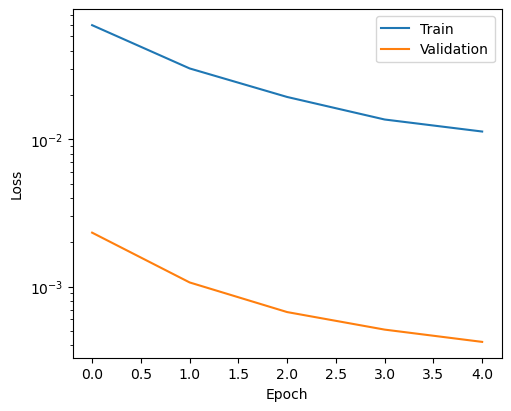

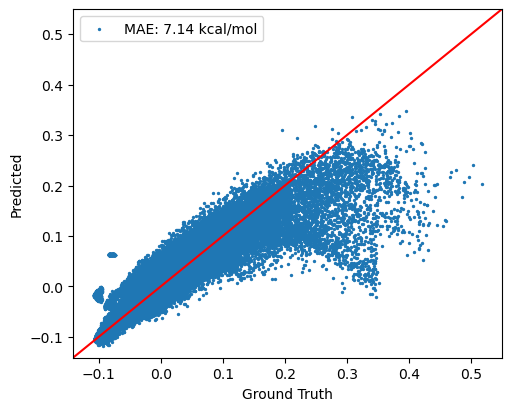

Validation Loss: 0.0004
-- Fold 2/3 --
Sequential - Number of parameters: 197636
Initializing training data...


 20%|██        | 1/5 [00:36<02:27, 36.84s/it]

In [ ]:
TrueKFoldCV_ANI(
    create_model_fn    = create_ani_model,
    trainer_class      = ANITrainer,
    full_dataset       = small_dataset,
    k                  = 3,
    dropout_rate       = 0.4,
    learning_rate      = 1e-4,
    batch_size         = 4096,
    epochs             = 5,
    l2                 = 0.0,
    l1                 = 1e-5,
    multiple_runs      = 3 
)